In [1]:
import zipfile
import os
import cv2
import shutil

import numpy as np
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt
import json
import re
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

In [26]:
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)
  
  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1

Importazione dati

In [32]:
# test set
#shutil.rmtree('test_set')
shutil.copytree(
    '/content/drive/MyDrive/DSIM/image_classification/test_set',
    'test_set/test_set'
    )

'test_set/test_set'

In [22]:
# labels mapping
shutil.copyfile(
    '/content/drive/MyDrive/DSIM/image_classification/map_classes.pkl',
    'map_classes.pkl'
    )
with open('map_classes.pkl', 'rb') as f:
  map_classes = pickle.load(f)
map_classes

{0: 'defocused_blurred', 1: 'motion_blurred', 2: 'sharp'}

Caricamento modello

In [3]:
# modello
shutil.copyfile(
    '/content/drive/MyDrive/DSIM/image_classification/final_model_image_classification.zip',
    'final_model_image_classification.zip'
    )

'final_model_image_classification.zip'

In [6]:
zip = zipfile.ZipFile('final_model_image_classification.zip')
zip.extractall('final_model_image_classification')
zip.close()

In [8]:
model = load_model('final_model_image_classification')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pre_trained (Functional)     (None, 14, 14, 256)       140480    
_________________________________________________________________
model (Functional)           (None, 3)                 3091459   
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


Generator test set

In [33]:
processing = image.ImageDataGenerator(
      preprocessing_function = applications.mobilenet.preprocess_input,
      validation_split = 0.2
      )
test_generator = processing.flow_from_directory(
      directory = 'test_set',
      target_size = (512, 384), 
      color_mode = 'rgb', 
      batch_size = 256,
      class_mode = 'categorical',
      shuffle = False,
      seed = 3
      )

Found 16 images belonging to 1 classes.


Prediction

In [34]:
test_prediction = model.predict(test_generator)
test_prediction

array([[3.1131065e-02, 9.1474903e-01, 5.4119945e-02],
       [4.1265252e-01, 4.9446040e-01, 9.2887156e-02],
       [2.3039505e-02, 9.5424497e-01, 2.2715567e-02],
       [1.3322377e-01, 2.2149125e-01, 6.4528501e-01],
       [5.6060027e-05, 1.3011458e-04, 9.9981385e-01],
       [2.2016676e-01, 6.2420583e-01, 1.5562737e-01],
       [1.1505249e-02, 9.7953343e-01, 8.9612324e-03],
       [1.5690204e-02, 9.7379827e-01, 1.0511520e-02],
       [5.4048661e-02, 4.8880103e-01, 4.5715031e-01],
       [3.5202764e-03, 9.9330372e-01, 3.1760428e-03],
       [2.2058419e-03, 3.8693580e-03, 9.9392480e-01],
       [4.8033357e-01, 4.4905972e-01, 7.0606649e-02],
       [2.7687587e-02, 5.7941353e-01, 3.9289886e-01],
       [6.6161883e-04, 9.9821150e-01, 1.1269328e-03],
       [1.6159983e-03, 9.9680531e-01, 1.5787504e-03],
       [2.1825539e-01, 5.3640932e-01, 2.4533530e-01]], dtype=float32)

In [42]:
test_data = pd.DataFrame({
     'filename' : test_generator.filenames,
     'output_class' : test_prediction.argmax(axis = -1)
     })

test_data['ground_truth'] = test_data['filename'].apply(lambda x: re.sub('\..*', '', x).split('_')[-1])
test_data['pred_label'] = test_data['output_class'].apply(lambda x: map_classes[x])
test_data['text'] = test_data.apply(
    lambda x: 'gt: ' + x['ground_truth'] + '\npred: ' + x['pred_label'],
    axis = 1)

test_data

,filename,output_class,ground_truth,pred_label,text
0,test_set/alpaca_sharp.jpg,1,sharp,motion_blurred,gt: sharp\npred: motion_blurred
1,test_set/autostrada_defocused.jpg,1,defocused,motion_blurred,gt: defocused\npred: motion_blurred
2,test_set/boltcorsa_motion.jpg,1,motion,motion_blurred,gt: motion\npred: motion_blurred
3,test_set/cane_sharp.png,2,sharp,sharp,gt: sharp\npred: sharp
4,test_set/colosseo_sharp.jpg,2,sharp,sharp,gt: sharp\npred: sharp
5,test_set/coso_motion.jpg,1,motion,motion_blurred,gt: motion\npred: motion_blurred
6,test_set/donna_defocused.jpg,1,defocused,motion_blurred,gt: defocused\npred: motion_blurred
7,test_set/folla_defocused.jpg,1,defocused,motion_blurred,gt: defocused\npred: motion_blurred
8,test_set/mare_sharp.jpg,1,sharp,motion_blurred,gt: sharp\npred: motion_blurred
9,test_set/mora_defocused.jpg,1,defocused,motion_blurred,gt: defocused\npred: motion_blurred


In [41]:
test_images = [
 cv2.cvtColor(cv2.imread('test_set/' + path), cv2.COLOR_BGR2RGB) for path in test_data['filename']
 ]

Visualizzazione risultati

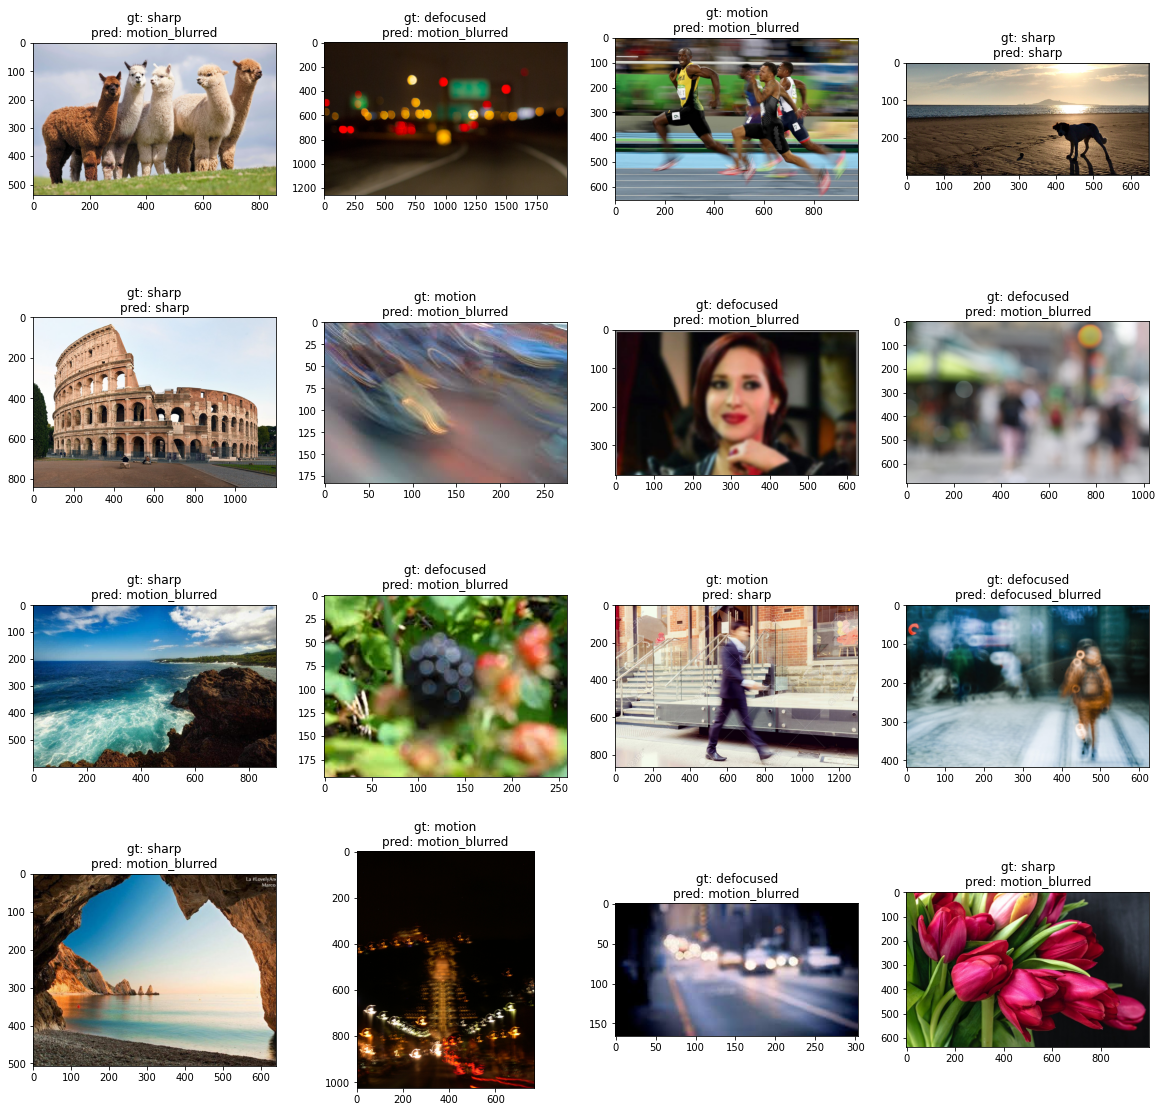

In [43]:
display_img(test_images, 4, 4, (20, 20), text = test_data['text'])

### Demo

In [48]:
def predict_blurr(image, model, map):
  image = cv2.resize(
    image,
    (224, 224)
  )
  prep = applications.mobilenet.preprocess_input(np.expand_dims(image, 0))
  return map[model.predict(prep).argmax()]

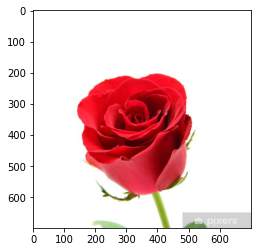

In [52]:
image = cv2.imread(
    '/content/drive/MyDrive/DSIM/image_classification/foto_demo/rosa_sharp.jpg'
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [53]:
predict_blurr(image, model, map_classes)

'sharp'